In [18]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.0 MB/s eta 0:00:00


In [19]:
import pandas as pd
import re
import spacy
from spacy.training import Example
import random

import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process

In [20]:
df = pd.read_csv("videos.csv")
df.head(10)

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http..."
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
5,youtube#video,32398,2021-10-06 01:28:59+00:00,39642,body lotion fit tuber 👈|| girls body lotion 👆|...,NaN,"['body lotion fit tuber', 'fit tuber body loti...",NaN,NaN,PT17S,1366.0,15.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
6,youtube#video,90721,2021-02-02 13:04:11+00:00,25860,"Contour Tutorial / How to do Contouring, Blush...",Makeup and Hair by @jagrutililawala\n\n#bride ...,NaN,NaN,NaN,PT1M34S,41.0,2.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
7,youtube#video,77725,2022-11-14 20:58:31+00:00,27788,Best look comes from the best products! #best ...,www.sopoli10x.com \n\n Beauty &Fashion. We re...,NaN,NaN,NaN,PT30S,1859.0,42.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
8,youtube#video,81779,2025-05-08 10:52:09+00:00,7310,Finishing touches. #blackgirlmakeup#makeup#bla...,NaN,NaN,NaN,NaN,PT30S,606.0,4.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
9,youtube#video,43693,2025-06-19 01:45:26+00:00,47519,glowup tips ✨️ #jenny #kpop #skincare #skincar...,#JennyGlowUp\n#KpopGlowUp\n#BeforeVsAfter\n#Gl...,NaN,en,en,PT11S,8951.0,172.0,0.0,5.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


### Data Cleaning

In [21]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove punctuation
    text = text.lower()
    return text

# Merge title, description, and tags into a single 'text' column (raw)
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['tags'].fillna('')
)

# Now clean it into 'clean_text'
df['clean_text'] = df['text'].apply(clean_text)

# Preview
df[['text', 'clean_text']].head(5)

,text,clean_text
0,Unlocking the Benefits of Face Masks for Skin ...,unlocking the benefits of face masks for skin ...
1,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,get ready for the magic hydration glowingskin ...
2,#trending #makeup #beautymakeup #yslbeauty #lu...,trending makeup beautymakeup yslbeauty luxury ...
3,#shortvedio #balayage,shortvedio balayage
4,Full Face of Merit Beauty 🤎 featuring new Flus...,full face of merit beauty featuring new flush...


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,text,clean_text,products
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http...",Unlocking the Benefits of Face Masks for Skin ...,unlocking benefits face masks skin health,[face mask]
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,get ready hydration glowingskin nomakeuplook s...,[]
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#trending #makeup #beautymakeup #yslbeauty #lu...,trending makeup beautymakeup yslbeauty luxury ...,[]
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#shortvedio #balayage,shortvedio balayage,[]
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Full Face of Merit Beauty 🤎 featuring new Flus...,full face merit beauty featuring new flush bal...,[]


### Spacy to extract products and brands

In [1]:
!pip install spacy-lookups-data
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import spacy
import random
import json
import tensorflow_datasets as tfds
from spacy.training import Example
from spacy.scorer import Scorer

In [7]:
OLD_TRAIN_DATA = [
    ("I love foundation and lipstick",
     {"entities": [(7, 17, "PRODUCT"), (22, 30, "PRODUCT")]}),

    ("lipstick and foundation are my faves",
     {"entities": [(0, 8, "PRODUCT"), (13, 23, "PRODUCT")]}),

    ("blush is amazing today",
     {"entities": [(0, 5, "PRODUCT")]}),

    ("perfume smells nice",
     {"entities": [(0, 7, "PRODUCT")]}),

    ("I just bought mascara & lipstick",
     {"entities": [(15, 21, "PRODUCT"), (25, 32, "PRODUCT")]}),

    ("highlighter, contour palette!",
     {"entities": [(0, 11, "PRODUCT"), (14, 29, "PRODUCT")]}),

    ("eyeshadow, blush, eyeliner",
     {"entities": [(0, 9, "PRODUCT"), (12, 16, "PRODUCT"), (19, 26, "PRODUCT")]}),

    ("lipstick lasts, mascara too",
     {"entities": [(0, 8, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("skincare moisturizer & blush",
     {"entities": [(0, 8, "PRODUCT"), (24, 28, "PRODUCT")]}),

    ("foundation is amazing",
     {"entities": [(0, 10, "PRODUCT")]}),

    ("eyeshadow palette and lip gloss",
     {"entities": [(0, 17, "PRODUCT"), (23, 31, "PRODUCT")]}),

    ("lip balm; concealer",
     {"entities": [(0, 9, "PRODUCT"), (12, 20, "PRODUCT")]}),

    ("eyebrow pencil, blush compact",
     {"entities": [(0, 14, "PRODUCT"), (17, 21, "PRODUCT")]}),

    ("mascara eyeliner",
     {"entities": [(0, 7, "PRODUCT"), (9, 16, "PRODUCT")]}),

    ("lip gloss, bronzer",
     {"entities": [(0, 9, "PRODUCT"), (12, 18, "PRODUCT")]}),

    ("foundation + lipstick",
     {"entities": [(0, 10, "PRODUCT"), (14, 21, "PRODUCT")]}),

    ("fragrance, lip balm, perfume",
     {"entities": [(0, 9, "PRODUCT"), (12, 19, "PRODUCT"), (22, 28, "PRODUCT")]}),

    ("blush, eyeliner, mascara",
     {"entities": [(0, 5, "PRODUCT"), (8, 15, "PRODUCT"), (18, 24, "PRODUCT")]}),

    ("bb cream, compact shell, brow pomade",
     {"entities": [(0, 8, "PRODUCT"), (11, 23, "PRODUCT"), (26, 36, "PRODUCT")]}),

    ("hip oil, bb cream, concealer",
     {"entities": [(0, 7, "PRODUCT"), (10, 17, "PRODUCT"), (20, 29, "PRODUCT")]}),

    ("hypercurl mascara, cheeky glow blush",
     {"entities": [(11, 17, "PRODUCT"), (32, 36, "PRODUCT")]}),

    ("megaglow highlighter, colorstay lip color",
     {"entities": [(10, 21, "PRODUCT")]}),

    ("benefits of face masks for skin health",
     {"entities": [(13, 22, "PRODUCT")]}),

    ("body serum",
     {"entities": [(0, 11, "PRODUCT")]}),

    ("deep conditioning like dancing shower shorts, deepconditioning",
     {"entities": [(0, 17, "PRODUCT"), (46, 62, "PRODUCT")]}),

    ("natural looking bronzer, orange bronzer",
     {"entities": [(16, 23, "PRODUCT"), (32, 39, "PRODUCT")]}),

    ("After trying the new highlighter and contour palette, my makeup looks amazing",
     {"entities": [(21, 32, "PRODUCT"), (37, 52, "PRODUCT")]}),

    ("Eyebrow pencil, blush compact, and lip gloss are all essentials in my kit",
     {"entities": [(0, 16, "PRODUCT"), (17, 29, "PRODUCT"), (35, 44, "PRODUCT")]}),

    ("Finally got the bb cream, compact shell, brow pomade, and body serum; my skin is loving it today",
     {"entities": [(16, 24, "PRODUCT"), (26, 39, "PRODUCT"), (41, 52, "PRODUCT"), (59, 68, "PRODUCT")]}),

    ("Trying out deep conditioning like dancing shower shorts and washday deepconditioning for the first time, feels so soft",
     {"entities": [(12, 28, "PRODUCT")]}),

    ("Natural looking bronzer, orange bronzer, hip oil, rose hip oil, and bb cream have been my go-to products this week",
     {"entities": [(17, 23, "PRODUCT"), (33, 39, "PRODUCT"), (42, 48, "PRODUCT"), (51, 62, "PRODUCT"), (69, 76, "PRODUCT")]}),

    ("Unlocking the benefits of face masks for skin health, body serum, and moisturizer has improved my daily routine",
     {"entities": [(27, 36, "PRODUCT"), (55, 64, "PRODUCT"), (70, 81, "PRODUCT")]}),

    ("Megaglow highlighter, colorstay lip color, cheeky glow blush, and hypercurl mascara have transformed my makeup looks",
     {"entities": [(10, 20, "PRODUCT"), (51, 60, "PRODUCT"), (77, 83, "PRODUCT")]}),

    ("I love Maybelline",
     {"entities": [(7, 17, "BRAND")]}),

    ("MAC is my go-to for makeup",
     {"entities": [(0, 3, "BRAND")]}),

    ("Nothing beats Fenty Beauty",
     {"entities": [(14, 26, "BRAND")]}),

    ("Sephora has great deals today",
     {"entities": [(0, 7, "BRAND")]}),

    ("I always trust L'Oreal products",
     {"entities": [(14, 20, "BRAND")]}),

    # --- Brands + Products ---
    ("Maybelline mascara is the best",
     {"entities": [(0, 10, "BRAND"), (11, 18, "PRODUCT")]}),

    ("MAC lipstick lasts all day",
     {"entities": [(0, 3, "BRAND"), (4, 12, "PRODUCT")]}),

    ("Fenty Beauty foundation matches me perfectly",
     {"entities": [(0, 12, "BRAND"), (13, 23, "PRODUCT")]}),

    ("I just bought L'Oreal blush",
     {"entities": [(13, 19, "BRAND"), (20, 25, "PRODUCT")]}),

    ("Sephora sells amazing eyeshadow palettes",
     {"entities": [(0, 7, "BRAND"), (21, 30, "PRODUCT")]}),

    ("shes not just bronzer shes the bronzer chanel makeup grwmmakeup fyp bronzer",
     {"entities": [(14, 21, "PRODUCT"), (31, 38, "PRODUCT"), (68, 75, "PRODUCT"), (39, 45, "BRAND")]}),

    ("self tanned and bronzed thanks to peta jane selftanner selftan bronzed selftanning",
     {"entities": []}),

    ("the science of sheet masks instantly revitalize your skin",
     {"entities": [(15, 26, "PRODUCT")]}),

    ("the benefits of clay masks purify and detoxify your skin",
     {"entities": [(16, 26, "PRODUCT")]}),

    ("best all in 1 serum trending serum serums serum whitening serum naicinamide serum alpha arbutin serum glutathione serum hyaluronic acid serum",
     {"entities": [(14, 19, "PRODUCT"), (29, 34, "PRODUCT"), (35, 40, "PRODUCT"),
                   (42, 47, "PRODUCT"), (58, 63, "PRODUCT"), (76, 81, "PRODUCT"),
                   (96, 101, "PRODUCT"), (114, 119, "PRODUCT"), (136, 141, "PRODUCT")]}),

    ("get instant face glow with london glow face powder instantglow facepowder",
     {"entities": [(27, 38, "BRAND"), (63, 73, "PRODUCT")]}),

    ("celebrating black queen styles with tuneful hair elevate your style with bold hair trends",
     {"entities": []}),

    ("best hair treatment beautyparlour kasturi haircolor love",
     {"entities": [(20, 33, "BRAND")]}),

    ("prisa bust fit secret serum diet jadi kendur itu pasti tapi kencengin lagi itu wajib",
     {"entities": [(0, 5, "BRAND"), (22, 27, "PRODUCT")]}),

    ("lais ribeiro glittery carnaval makeup look beauty secrets neutrogena moisturizing hydro boost hydrating face mask",
     {"entities": [(0, 12, "BRAND"), (58, 68, "BRAND"), (104, 113, "PRODUCT")]}),

    ("ponds makeup remover wipes original fresh",
     {"entities": [(0, 5, "BRAND"), (6, 20, "PRODUCT")]}),

    ("bobbi brown skin longwear weightless foundation spf 15",
     {"entities": [(0, 11, "BRAND"), (37, 47, "PRODUCT")]}),

    ("pat mcgrath eyeshadow palette",
     {"entities": [(0, 11, "BRAND"), (12, 29, "PRODUCT")]}),

    ("charlotte tilbury glowgasm beauty highlighter wand",
     {"entities": [(0, 17, "BRAND"), (34, 45, "PRODUCT")]}),

    ("charlotte tilbury cheek to chic blush in pillow talk intense",
     {"entities": [(0, 17, "BRAND"), (32, 37, "PRODUCT")]}),

    ("mac silver stars glitter",
     {"entities": [(0, 3, "BRAND"), (19, 26, "PRODUCT")]}),

    ("trending lipstick beautifulgirl girl trending",
     {"entities": [(9, 17, "PRODUCT")]}),

    ("ash ombre h2bsalon ash ombre hair haircolor trending kamlanagar",
     {"entities": []}),

    ("nails nail art nail design nail nail video nail tutorial nail polish",
     {"entities": [(57, 68, "PRODUCT")]}),

    ("selena gomez rare beauty thanks for watching",
     {"entities": [(13, 24, "BRAND")]}),

    ("hair dye transformation vibes vibewithus couplegoals",
     {"entities": []}),

    ("maybelline hyper curl mascara long lasting pigmented",
     {"entities": [(0, 10, "BRAND"), (22, 29, "PRODUCT")]}),
]


In [10]:
import pandas as pd
import random
import spacy
from spacy.training import Example
from spacy.scorer import Scorer

# 1. Load data
df = pd.read_csv("products.csv")  # adjust path

# 2. Clean
df = df.dropna(subset=["name", "brand"])
df = df.reset_index(drop=True)

# Optional: take a subset if it's very large
df_small = df.sample(n=1000, random_state=42)

# 3. Build spaCy-formatted examples
TRAIN_DATA = []

for _, row in df_small.iterrows():
    brand = str(row["brand"]).strip()
    product = str(row["name"]).strip()
    # Build sentence
    text = f"I have just bought {brand} {product} and I love it"

    # Lower or maintain casing? spaCy works with original casing, but you can vary
    # Find spans
    brand_start = text.lower().find(brand.lower())
    if brand_start < 0:
        continue  # skip if brand not found
    brand_end = brand_start + len(brand)

    product_start = text.lower().find(product.lower(), brand_end)  # after brand
    if product_start < 0:
        # product not found (maybe product name is complex). Try simpler sentence:
        text2 = f"My new product is a {product} from {brand}"
        # recompute
        product_start = text2.lower().find(product.lower())
        brand_start2 = text2.lower().find(brand.lower())
        if product_start < 0 or brand_start2 < 0:
            continue
        entities = [
            (product_start, product_start + len(product), "PRODUCT"),
            (brand_start2, brand_start2 + len(brand), "BRAND")
        ]
        TRAIN_DATA.append((text2, {"entities": entities}))
    else:
        entities = [
            (brand_start, brand_end, "BRAND"),
            (product_start, product_start + len(product), "PRODUCT")
        ]
        TRAIN_DATA.append((text, {"entities": entities}))

# 4. Add negative / brand-only / product-only examples
for _ in range(200):
    # Negative example
    TRAIN_DATA.append(("I just walked into the store today", {"entities": []}))
for _, row in df_small.sample(n=200, random_state=7).iterrows():
    product = str(row["name"]).strip()
    text = f"This product is called {product}"
    start = text.lower().find(product.lower())
    if start < 0:
        continue
    TRAIN_DATA.append((text, {"entities": [(start, start + len(product), "PRODUCT")]}))

for _, row in df_small.sample(n=200, random_state=8).iterrows():
    brand = str(row["brand"]).strip()
    text = f"I love the brand {brand}"
    start = text.lower().find(brand.lower())
    if start < 0:
        continue
    TRAIN_DATA.append((text, {"entities": [(start, start + len(brand), "BRAND")]}))
NEW_TRAIN_DATA = TRAIN_DATA + OLD_TRAIN_DATA


In [16]:
print(f"New TRAIN_DATA size: {len(TRAIN_DATA)}")
print(f"Old TRAIN_DATA size: {len(OLD_TRAIN_DATA)}")
print(f"Total NEW_TRAIN_DATA size: {len(NEW_TRAIN_DATA)}")

New TRAIN_DATA size: 1600
Old TRAIN_DATA size: 65
Total NEW_TRAIN_DATA size: 1665


In [11]:
random.shuffle(NEW_TRAIN_DATA)
split = int(0.8 * len(NEW_TRAIN_DATA))
TRAIN_SPLIT = NEW_TRAIN_DATA[:split]
TEST_SPLIT = NEW_TRAIN_DATA[split:]

nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")
ner.add_label("BRAND")
ner.add_label("PRODUCT")

optimizer = nlp.begin_training()
for epoch in range(15):
    random.shuffle(TRAIN_SPLIT)
    losses = {}
    for text, annotations in TRAIN_SPLIT:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        nlp.update([example], drop=0.25, losses=losses)
    print(f"Epoch {epoch+1}: {losses}")


/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Finally got the bb cream, compact shell, brow poma..." with entities "[(16, 24, 'PRODUCT'), (26, 39, 'PRODUCT'), (41, 52...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "lipstick lasts, mascara too" with entities "[(0, 8, 'PRODUCT'), (18, 24, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "hypercurl mascara,

Epoch 1: {'ner': np.float32(1365.562)}
Epoch 2: {'ner': np.float32(324.08026)}
Epoch 3: {'ner': np.float32(246.77193)}
Epoch 4: {'ner': np.float32(158.6213)}
Epoch 5: {'ner': np.float32(172.22995)}
Epoch 6: {'ner': np.float32(162.44888)}
Epoch 7: {'ner': np.float32(139.0211)}
Epoch 8: {'ner': np.float32(93.023285)}
Epoch 9: {'ner': np.float32(113.84041)}
Epoch 10: {'ner': np.float32(89.75267)}
Epoch 11: {'ner': np.float32(72.851)}
Epoch 12: {'ner': np.float32(111.13883)}
Epoch 13: {'ner': np.float32(68.769165)}
Epoch 14: {'ner': np.float32(25.873755)}
Epoch 15: {'ner': np.float32(99.87173)}


In [12]:
examples = []
for text, annotations in TEST_SPLIT:
    doc = nlp(text)
    examples.append(Example.from_dict(doc, annotations))

scorer = Scorer()
scores = scorer.score(examples)
print("Precision:", scores["ents_p"])
print("Recall:", scores["ents_r"])
print("F1-score:", scores["ents_f"])
print("Detailed per-entity type results:")
for ent, m in scores["ents_per_type"].items():
    print(ent, m)

/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "eyeshadow palette and lip gloss" with entities "[(0, 17, 'PRODUCT'), (23, 31, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Trying out deep conditioning like dancing shower s..." with entities "[(12, 28, 'PRODUCT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "lip gloss, bronzer" with entities "[(0, 9, 'P

Precision: 0.9567779960707269
Recall: 0.9586614173228346
F1-score: 0.9577187807276303
Detailed per-entity type results:
BRAND {'p': 0.9683794466403162, 'r': 0.9607843137254902, 'f': 0.9645669291338583}
PRODUCT {'p': 0.9453125, 'r': 0.9565217391304348, 'f': 0.9508840864440079}


In [13]:
nlp.to_disk("beauty_ner")

In [22]:
nlp = spacy.load("beauty_ner")

def extract_entities(text):
    doc = nlp(text)
    products = [ent.text for ent in doc.ents if ent.label_ == "PRODUCT"]
    brands = [ent.text for ent in doc.ents if ent.label_ == "BRAND"]
    return products, brands

df[['products', 'brands']] = df['clean_text'].apply(
    lambda x: pd.Series(extract_entities(x))
)

In [24]:
df.head(5)

,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,text,clean_text,products,brands
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,NaN,NaN,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http...",Unlocking the Benefits of Face Masks for Skin ...,unlocking the benefits of face masks for skin ...,[face masks],[]
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,NaN,NaN,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,get ready for the magic hydration glowingskin ...,[hydration],[]
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,NaN,NaN,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#trending #makeup #beautymakeup #yslbeauty #lu...,trending makeup beautymakeup yslbeauty luxury ...,[],[]
3,youtube#video,45298,2023-07-13 15:19:28+00:00,50139,#shortvedio #balayage,NaN,NaN,NaN,NaN,PT14S,1207.0,20.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,#shortvedio #balayage,shortvedio balayage,[balayage],[]
4,youtube#video,43611,2023-04-29 18:47:37+00:00,8143,Full Face of Merit Beauty 🤎 featuring new Flus...,NaN,NaN,NaN,en,PT56S,8647.0,268.0,0.0,7.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,Full Face of Merit Beauty 🤎 featuring new Flus...,full face of merit beauty featuring new flush...,"[merit beauty, flush balm, makeuptutorial ]",[full]


In [ ]:
df.to_csv("youtube_beauty_products.csv", index=False)

### Predicted Trending Products and Brands

In [ ]:
import pandas as pd
import re

# Load CSV files
df_beauty = pd.read_csv("youtube_beauty_products1.csv")  # beauty file
df_trend = pd.read_csv("trend_both_youtube.csv")        # trend file

# --- Normalize products/brands from beauty file ---
def normalize_list(col):
    if pd.isna(col):
        return []
    if isinstance(col, str):
        col = col.strip("[]")
        return [c.strip().strip("'\"") for c in col.split(",") if c.strip()]
    if isinstance(col, list):
        return col
    return []

df_beauty['products'] = df_beauty['products'].apply(normalize_list)
df_beauty['brands']   = df_beauty['brands'].apply(normalize_list)

# --- Extract hashtags from text ---
def extract_hashtags(text):
    return re.findall(r"#(\w+)", str(text))

# --- Initialize columns in trend file ---
df_trend['products'] = [[] for _ in range(len(df_trend))]
df_trend['brands']   = [[] for _ in range(len(df_trend))]

# --- Merge products & brands into trend file (keep duplicates) ---
for idx_trend, trend_row in df_trend.iterrows():
    trend_id = str(trend_row['trend_id']).lstrip("#")  # remove extra # to match hashtags

    for _, beauty_row in df_beauty.iterrows():
        text_hashtags = extract_hashtags(beauty_row['text'])  # or 'clean_text'

        if trend_id in text_hashtags:
            df_trend.at[idx_trend, 'products'].extend(beauty_row['products'])
            df_trend.at[idx_trend, 'brands'].extend(beauty_row['brands'])

# --- Convert lists to strings for saving ---
df_trend['products'] = df_trend['products'].apply(lambda x: ', '.join(x))
df_trend['brands']   = df_trend['brands'].apply(lambda x: ', '.join(x))

# --- Save updated file ---
df_trend.to_csv("trend_both_youtube_updated.csv", index=False, encoding="utf-8-sig")
print("✅ Updated trend file saved as trend_both_youtube_updated.csv")

# Preview
df_trend[['trend_id', 'products', 'brands']].head(10)

✅ Updated trend file saved as trend_both_youtube_updated.csv


,trend_id,products,brands
0,##shorts,"moisturizer, body lotion, body moisturizer, fa...","Fresh, Pixi, Maybelline, Fresh, Laneige, Chane..."
1,##makeup,"bronzer, contour, lipstick, lipstick, eyeliner...","Chanel, Rare Beauty, Rare Beauty, NYX, MAC, La..."
2,##yoga,"gua sha, gua sha, comb, contour, contour, gua ...","OPI, Ilia, Bulldog, OPI, OPI, MAC, OPI, Ilia, ..."
3,##facelift,"gua sha, contour, contour, gua sha, contour, b...","Ilia, OPI, MAC, Innisfree, Laneige, CosRX, Law..."
4,##beauty,"foundation, lipstick, mascara, eyeshadow, blus...","Maybelline, MAC, OPI, Chanel, Urban Decay, Nat..."
5,##skincare,"face powder, face powder, blush, lipstick, eye...","Rare Beauty, Rare Beauty, OPI, Ilia, Bulldog, ..."
6,##youtubeshorts,"face mask, foundation, blush, hair mask, found...","Fresh, Chanel, Ilia, Maybelline, Huda Beauty, ..."
7,##trending,"lipstick, eyeliner, eyeshadow, face mask, hair...","Pixi, Laneige, Bulldog, Maybelline, MAC, MAC, ..."
8,##wrinkles,"gua sha, jade roller, gua sha, comb, contour, ...","Innisfree, Laneige, CosRX, OPI, OPI, MAC, MAC,..."
9,##faceyoga,"gua sha, gua sha, comb, contour, contour, gua ...","OPI, Ilia, Bulldog, OPI, OPI, OPI, OPI, Ilia, ..."


In [ ]:
# Select only trend_id and brands
df_trend_brands = df_trend[['trend_id', 'brands']]

# Save to CSV
df_trend_brands.to_csv("trend_brands_only.csv", index=False, encoding="utf-8-sig")

print("✅ Saved trend_id and brands to 'trend_brands_only.csv'")

✅ Saved trend_id and brands to 'trend_brands_only.csv'


/tmp/ipython-input-3715366179.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='product', y='count', data=top_10_products, palette='viridis')


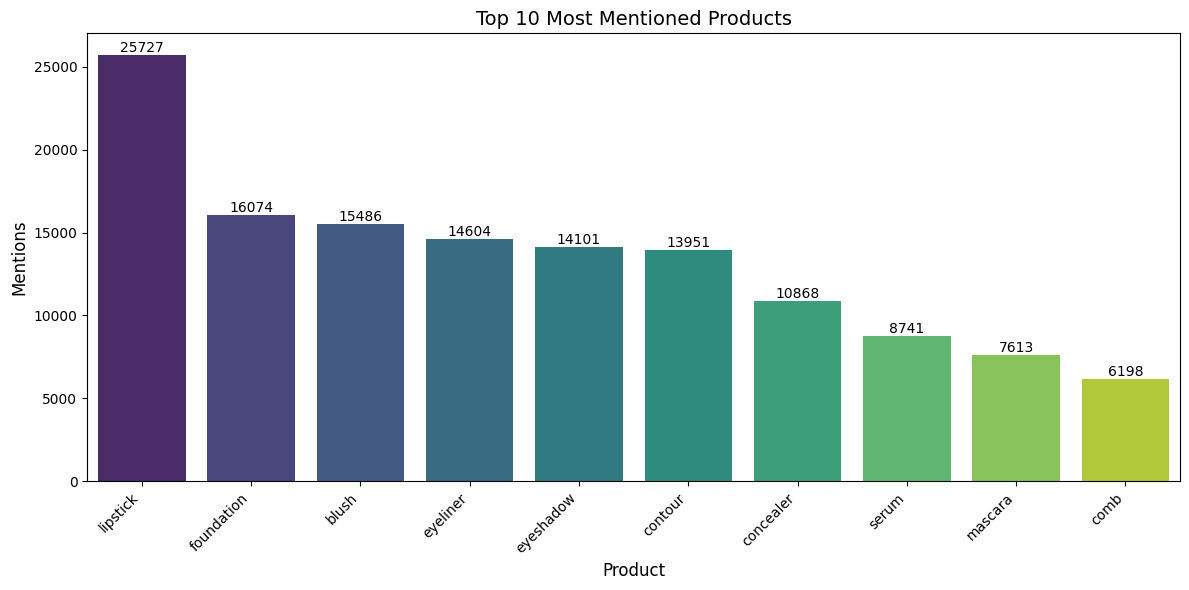

In [ ]:
df_trend = pd.read_csv("trend_both_youtube_updated.csv")

# --- Normalize helper ---
def normalize_list(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, str):
        return [c.strip() for c in cell.split(",") if c.strip()]
    return cell

df_trend['products'] = df_trend['products'].apply(normalize_list)
df_trend['brands']   = df_trend['brands'].apply(normalize_list)

# --- PRODUCTS ---
all_products = [prod for sublist in df_trend['products'] for prod in sublist]
product_counts = Counter(all_products)
product_counts_df = pd.DataFrame(product_counts.items(), columns=['product', 'count']).sort_values(by='count', ascending=False)

top_10_products = product_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='product', y='count', data=top_10_products, palette='viridis')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height), ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Most Mentioned Products", fontsize=14)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-100616087.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')


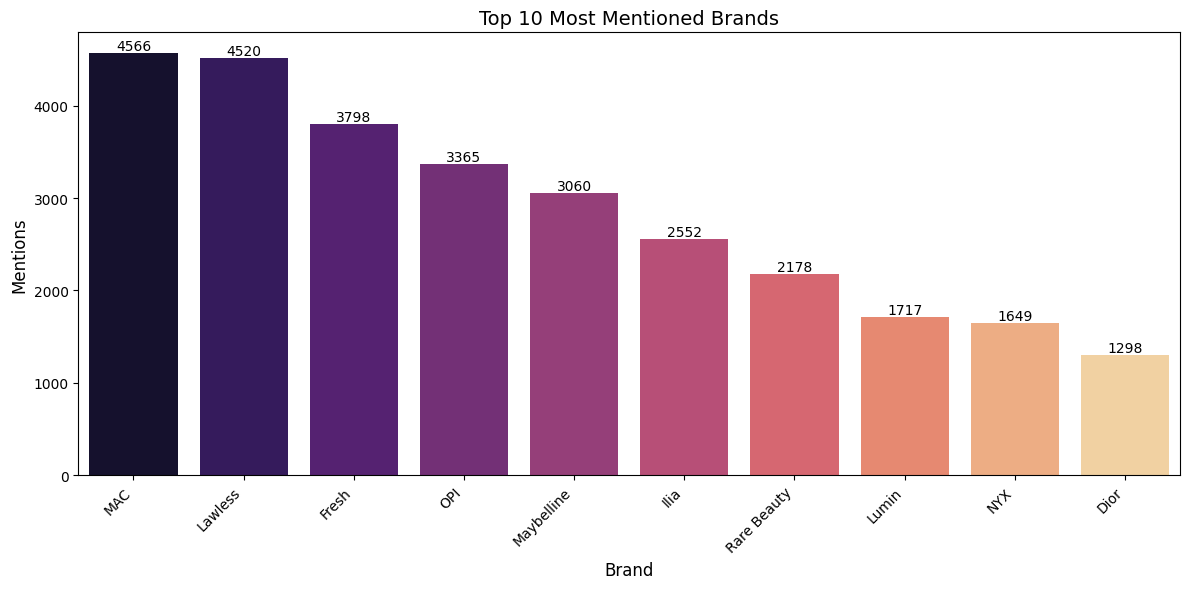

In [ ]:
all_brands = [brand for sublist in df_trend['brands'] for brand in sublist]
brand_counts = Counter(all_brands)
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['brand', 'count']).sort_values(by='count', ascending=False)

top_10_brands = brand_counts_df.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(x='brand', y='count', data=top_10_brands, palette='magma')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height), ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Most Mentioned Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Mentions", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import json

trend_100_products = product_counts_df.head(100).to_dict(orient="records")
trend_100_brands   = brand_counts_df.head(100).to_dict(orient="records")

with open("trend_100_products.json", "w", encoding="utf-8") as f:
    json.dump(trend_100_products, f, ensure_ascii=False, indent=2)

with open("trend_100_brands.json", "w", encoding="utf-8") as f:
    json.dump(trend_100_brands, f, ensure_ascii=False, indent=2)

print("Saved top 100 products and brands to JSON files.")

Saved top 100 products and brands to JSON files.


### Trending product based on weight


=== Top 10 Products with Mentions and Weighted Score ===

               product  weighted_score  mentions
128      cream contour        7.857980        41
69          hand cream        7.702313        42
117           lip mask        6.672084        36
156        lip plumper        6.259573        30
188         detox mask        5.943033        33
101     powder contour        5.742082        26
142           hair tie        5.470640        24
146        massage oil        5.433396        28
129        night serum        5.206884        27
71   cream highlighter        5.181128        23


/tmp/ipython-input-2688988729.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


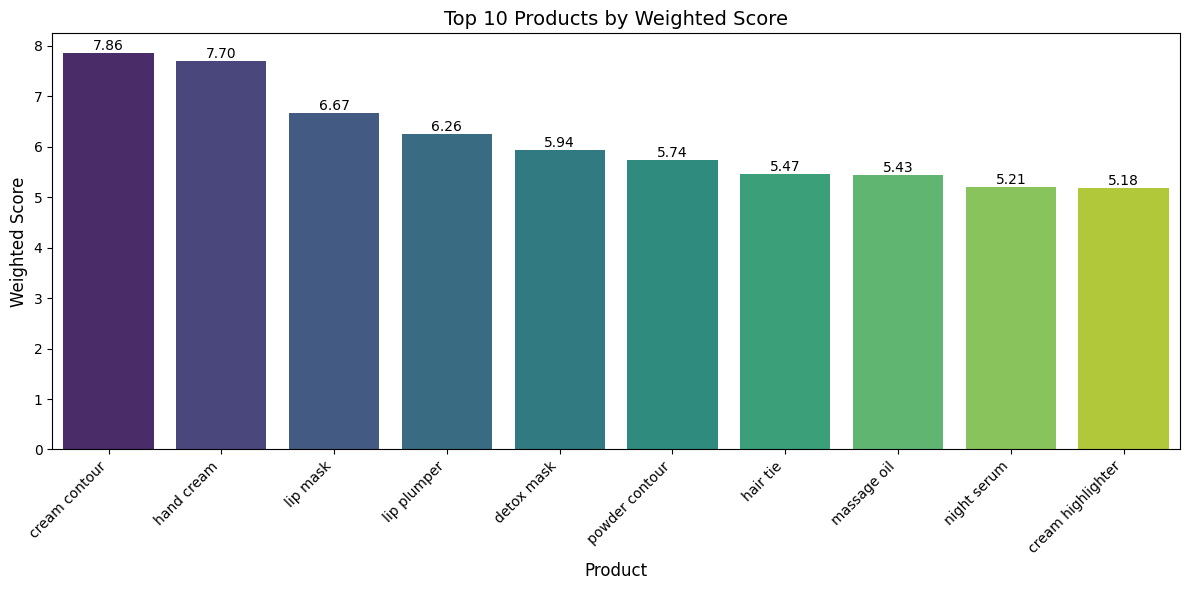

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load data
df = pd.read_csv("trend_both_youtube_updated.csv")

# Normalize factors
factors = ["volume", "engagement", "growth_rate_7d", "acceleration"]
scaler = MinMaxScaler()
df_norm = pd.DataFrame(
    scaler.fit_transform(df[factors]),
    columns=[f"{f}_norm" for f in factors]
)
df = pd.concat([df, df_norm], axis=1)

# Forecast score (weighted index)
df["forecast_score"] = (
    df["volume_norm"] * 0.4 +
    df["engagement_norm"] * 0.3 +
    df["growth_rate_7d_norm"] * 0.2 +
    df["acceleration_norm"] * 0.1
)

# --- Initialize dicts ---
product_scores = defaultdict(float)
product_mentions = defaultdict(int)

# Loop through each trend
for _, row in df.iterrows():
    if pd.notna(row["products"]):
        # Split comma-separated products, remove extra spaces
        products = [p.strip().lower() for p in row["products"].split(",")]

        for p in products:
            product_scores[p] += row["forecast_score"]  # add trend score for each occurrence
            product_mentions[p] += 1                    # add mention for each occurrence

# Create DataFrame
product_df = pd.DataFrame({
    "product": list(product_scores.keys()),
    "weighted_score": [product_scores[p] for p in product_scores.keys()],
    "mentions": [product_mentions[p] for p in product_scores.keys()]
})

# Sort by weighted_score descending
product_df = product_df.sort_values(by="weighted_score", ascending=False)

# Top 10 products
top_10_products = product_df.head(10)
print("\n=== Top 10 Products with Mentions and Weighted Score ===\n")
print(top_10_products)

# Save top 100
top_100_products = product_df.head(100)
top_100_products.to_json(
    "top_100_products_with_score_mentions.json",
    orient="records",
    indent=2
)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x="product",
    y="weighted_score",
    data=top_10_products,
    palette="viridis"
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Products by Weighted Score", fontsize=14)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Weighted Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



=== Top 10 Brands with Mentions and Weighted Score ===

             brand  weighted_score  mentions
111         mugler       45.347880       239
51          wardah       21.729287        90
67     moroccanoil       20.256604        94
110          aveda       18.869475        66
121    glow recipe       16.893279        75
60        peripera       13.433681        53
123         kopari       13.332814        48
107        canmake       13.107901        36
66   the face shop       11.959174        46
29     dermalogica       11.589627        45


/tmp/ipython-input-1442476122.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


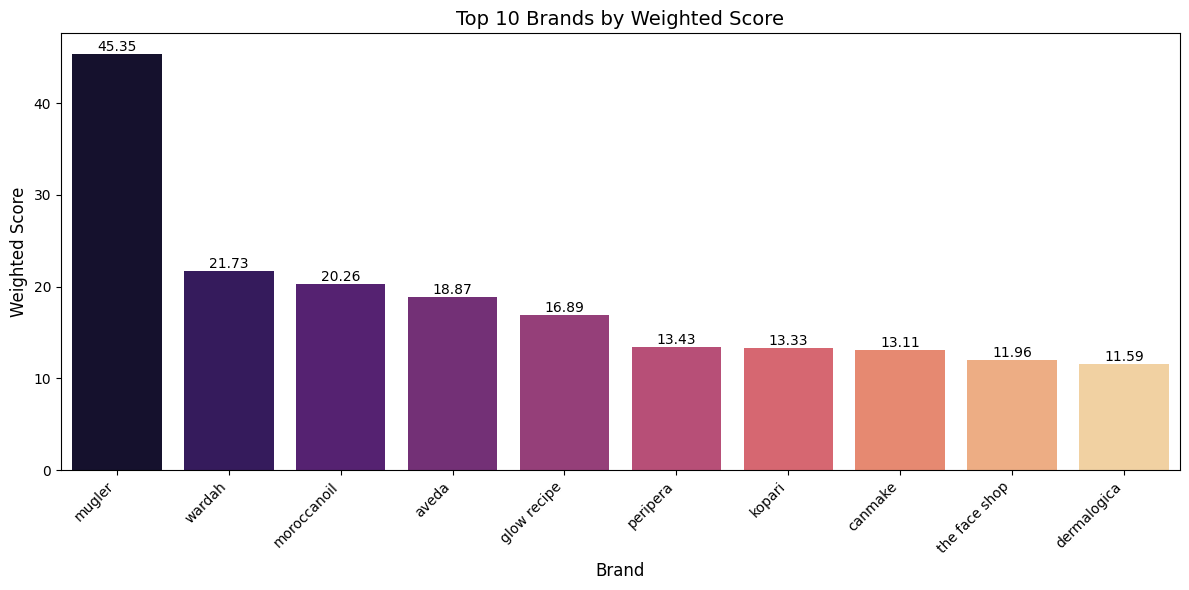

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load data
df = pd.read_csv("trend_both_youtube_updated.csv")

# Normalize factors
factors = ["volume", "engagement", "growth_rate_7d", "acceleration"]
scaler = MinMaxScaler()
df_norm = pd.DataFrame(
    scaler.fit_transform(df[factors]),
    columns=[f"{f}_norm" for f in factors]
)
df = pd.concat([df, df_norm], axis=1)

# Forecast score (weighted index)
df["forecast_score"] = (
    df["volume_norm"] * 0.4 +
    df["engagement_norm"] * 0.3 +
    df["growth_rate_7d_norm"] * 0.2 +
    df["acceleration_norm"] * 0.1
)

# --- Initialize dicts ---
brand_scores = defaultdict(float)
brand_mentions = defaultdict(int)

# Loop through each trend
for _, row in df.iterrows():
    if pd.notna(row["brands"]):  # change column name to your brands column
        # Split comma-separated brands, remove extra spaces
        brands = [b.strip().lower() for b in row["brands"].split(",")]

        for b in brands:
            brand_scores[b] += row["forecast_score"]  # add trend score for each occurrence
            brand_mentions[b] += 1                    # add mention for each occurrence

# Create DataFrame
brand_df = pd.DataFrame({
    "brand": list(brand_scores.keys()),
    "weighted_score": [brand_scores[b] for b in brand_scores.keys()],
    "mentions": [brand_mentions[b] for b in brand_scores.keys()]
})

# Sort by weighted_score descending
brand_df = brand_df.sort_values(by="weighted_score", ascending=False)

# Top 10 brands
top_10_brands = brand_df.head(10)
print("\n=== Top 10 Brands with Mentions and Weighted Score ===\n")
print(top_10_brands)

# Save top 100
top_100_brands = brand_df.head(100)
top_100_brands.to_json(
    "top_100_brands_with_score_mentions.json",
    orient="records",
    indent=2
)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x="brand",
    y="weighted_score",
    data=top_10_brands,
    palette="magma"
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width()/2, height),
                ha='center', va='bottom', fontsize=10)
plt.title("Top 10 Brands by Weighted Score", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Weighted Score", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
top_10_brands = (
    df.groupby("brands", dropna=True)
    .agg({"forecast_score": "mean"})
    .reset_index()
    .sort_values(by="forecast_score", ascending=False)
    .head(10)
)

print("\n=== Top 10 Forecasted Beauty Brands ===\n")
print(top_10_brands)

top_100_brands = (
    df.groupby("brands", dropna=True)
    .agg({"forecast_score": "mean"})
    .reset_index()
    .sort_values(by="forecast_score", ascending=False)
    .head(100)
)

top_100_brands.to_json("top_100_forecasted_brands.json", orient="records", indent=2)

print("✅ Top 100 brands saved to 'top_100_forecasted_brands.json'")

plt.figure(figsize=(12,6))
sns.barplot(x="forecast_score", y="brands", data=top_10_brands, palette="magma")
plt.title("Top 10 Forecasted Trending Beauty Brands", fontsize=14)
plt.xlabel("Forecast Score", fontsize=12)
plt.ylabel("Brand", fontsize=12)
plt.tight_layout()
plt.show()

### Match trends with Loreal Products

In [ ]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

In [ ]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
from fuzzywuzzy import fuzz

# === Load files ===
csv_path = "trend_both_youtube_updated.csv"
brands_path = "loreal_brands.json"
products_path = "loreal_products.json"

df = pd.read_csv(csv_path)

with open(brands_path, "r", encoding="utf-8") as f:
    brands_data = json.load(f)

with open(products_path, "r", encoding="utf-8") as f:
    products_data = json.load(f)

# === Flatten brand data ===
brand_list = []
for category, items in brands_data.items():
    for b in items:
        brand_list.append({
            "brand": b["brand"],
            "description": b["description"],
            "category": category
        })

# === Flatten product data ===
product_list = [{"title": p["title"], "description": p["description"]} for p in products_data]

# === Matching functions ===
def get_best_product(products_str):
    """Return the single best-matching L'Oréal product"""
    if pd.isna(products_str):
        return None

    products = [p.strip().lower() for p in products_str.split(",")]
    best_score = 0
    best_product = None

    for prod in products:
        for item in product_list:
            score_title = fuzz.partial_ratio(prod, item["title"].lower())
            score_desc = fuzz.partial_ratio(prod, item["description"].lower())
            score = max(score_title, score_desc)
            if score > best_score:
                best_score = score
                best_product = item["title"]
    return best_product

def get_best_brands(trend_id, products_str, top_n=3):
    """Return 1–3 best-matching brands"""
    text = (str(trend_id) + " " + str(products_str)).lower()
    scored = []
    for b in brand_list:
        score_brand = fuzz.partial_ratio(b["brand"].lower(), text)
        score_desc = fuzz.partial_ratio(b["description"].lower(), text)
        score = max(score_brand, score_desc)
        if score > 50:  # relevance threshold
            scored.append((b["brand"], score))
    scored = sorted(scored, key=lambda x: x[1], reverse=True)
    best_brands = [s[0] for s in scored[:top_n]]
    return best_brands if best_brands else None

# === Apply to dataset ===
df["best_loreal_product"] = df["products"].apply(get_best_product)
df["best_brands"] = df.apply(lambda x: get_best_brands(x["trend_id"], x["products"]), axis=1)

# === Save result ===
output_path = "trend_with_loreal_mapping.csv"
df.to_csv(output_path, index=False)

print(f"✅ New CSV saved to {output_path}")

✅ New CSV saved to trend_with_loreal_mapping.csv


In [ ]:
df.head(5)

,trend_id,token_type,platform,date,volume,engagement,audience_signals,category,geo,raw_token,growth_rate_7d,acceleration,current_stage,recommended_action,products,best_loreal_product,best_brands
0,##shorts,hashtag,youtube,2025-09-07,9739,37255097,"{'gen_z': np.float64(0.75), 'millennials': np....","['lifestyle', 'health', 'general']","['hi', 'en', 'ru', 'ur', 'en-GB', 'en-IN', 'en...",##shorts,-0.111,0.667,peak,Maintain visibility,"moisturizer, body lotion, face powder, lipstic...",Glycolic Bright\nGlycolic Bright 8% [Melasyl ™...,"[Garnier, Maybelline New York, NYX Professiona..."
1,##makeup,hashtag,youtube,2025-09-07,4091,70248158,"{'gen_z': np.float64(0.46), 'millennials': np....","['lifestyle', 'general', 'health']","['en', 'en-GB', 'hi', 'en-IN', 'ml', 'es', 'id...",##makeup,0.000,-0.333,declining,Too late,"bronzer, contour, lipstick, eyeliner, eyeshado...",Infallible Lip Makeup\nInfallible Matte Resist...,"[Garnier, Maybelline New York]"
2,##yoga,hashtag,youtube,2025-09-07,3075,1352141,"{'gen_z': np.float64(0.49), 'millennials': np....","['health', 'lifestyle', 'general']","['hi', 'en', 'en-IN', 'zxx']",##yoga,1.000,0.333,emerging,Hop on now,"gua sha, comb, contour, lipstick, serum, acne ...",Glycolic Bright\nAnti-Dark Spot Exfoliant Peel,"[Essie, Armani Beauty, Maison Margiela]"
3,##facelift,hashtag,youtube,2025-09-07,2407,616522,"{'gen_z': np.float64(0.66), 'millennials': np....","['health', 'lifestyle']","['en-US', 'es', 'en', 'zxx', 'hi']",##facelift,0.000,0.667,peak,Maintain visibility,"gua sha, contour, blush, bronzer, highlighter,...",Infallible\nFull Wear More Than Concealer,"[CeraVe, Garnier]"
4,##beauty,hashtag,youtube,2025-09-07,2038,44001722,"{'gen_z': np.float64(0.44), 'millennials': np....","['lifestyle', 'general', 'health']","['en-US', 'en', 'hi', 'en-IN', 'en-GB', 'id', ...",##beauty,0.000,0.000,declining,Too late,"foundation, lipstick, mascara, eyeshadow, blus...",Infallible\n32H FreshWear Foundation,"[Carita, Valentino, Urban Decay]"
